<a href="https://colab.research.google.com/github/VeraMendes/DS-Unit-2-Kaggle-Challenge/blob/master/module1/Vera_Mendes_Assignment_kaggle_challenge_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science, Unit 2: Predictive Modeling

# Kaggle Challenge, Module 1

## Assignment
- [ ] Do train/validate/test split with the Tanzania Waterpumps data.
- [ ] Define a function to wrangle train, validate, and test sets in the same way. Clean outliers and engineer features. (For example, [what other columns have zeros and shouldn't?](https://github.com/Quartz/bad-data-guide#zeros-replace-missing-values) What other columns are duplicates, or nearly duplicates? Can you extract the year from date_recorded? Can you engineer new features, such as the number of years from waterpump construction to waterpump inspection?)
- [ ] Select features. Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.
- [ ] Get your validation accuracy score.
- [ ] Get and plot your feature importances.
- [ ] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

### Reading

- A Visual Introduction to Machine Learning
  - [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)
  - [Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
- [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU) — _Don’t worry about understanding the code, just get introduced to the concepts. This 10 minute video has excellent diagrams and explanations._
- [Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)


### Doing
- [ ] Add your own stretch goal(s) !
- [ ] Try other [scikit-learn imputers](https://scikit-learn.org/stable/modules/impute.html).
- [ ] Make exploratory visualizations and share on Slack.


#### Exploratory visualizations

Visualize the relationships between feature(s) and target. I recommend you do this with your training set, after splitting your data. 

For this problem, you may want to create a new column to represent the target as a number, 0 or 1. For example:

```python
train['functional'] = (train['status_group']=='functional').astype(int)
```



You can try [Seaborn "Categorical estimate" plots](https://seaborn.pydata.org/tutorial/categorical.html) for features with reasonably few unique values. (With too many unique values, the plot is unreadable.)

- Categorical features. (If there are too many unique values, you can replace less frequent values with "OTHER.")
- Numeric features. (If there are too many unique values, you can [bin with pandas cut / qcut functions](https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html?highlight=qcut#discretization-and-quantiling).)

You can try [Seaborn linear model plots](https://seaborn.pydata.org/tutorial/regression.html) with numeric features. For this classification problem, you may want to use the parameter `logistic=True`, but it can be slow.

You do _not_ need to use Seaborn, but it's nice because it includes confidence intervals to visualize uncertainty.

#### High-cardinality categoricals

This code from a previous assignment demonstrates how to replace less frequent values with 'OTHER'

```python
# Reduce cardinality for NEIGHBORHOOD feature ...

# Get a list of the top 10 neighborhoods
top10 = train['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10,
# replace the neighborhood with 'OTHER'
train.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
test.loc[~test['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
```


In [1]:
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

     |████████████████████████████████| 102kB 4.4MB/s 


In [0]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import plotly.express as px
import pandas_profiling
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer

In [138]:
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

train.shape, test.shape

((59400, 41), (14358, 40))

In [13]:
train.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
43360,72938,0.0,2011-07-27,NaN,0,NaN,33.542898,-9.174777,Kwa Mzee Noa,0,Lake Nyasa,Mpandapanda,Mbeya,12,4,Rungwe,Kiwira,0,True,GeoData Consultants Ltd,VWC,K,NaN,0,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,functional
7263,65358,500.0,2011-03-23,Rc Church,2049,ACRA,34.665760,-9.308548,Kwa Yasinta Ng'Ande,0,Rufiji,Kitichi,Iringa,11,4,Njombe,Imalinyi,175,True,GeoData Consultants Ltd,WUA,Tove Mtwango gravity Scheme,True,2008,gravity,gravity,gravity,wua,user-group,pay monthly,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
2486,469,25.0,2011-03-07,Donor,290,Do,38.238568,-6.179919,Kwasungwini,0,Wami / Ruvu,Kwedigongo,Pwani,6,1,Bagamoyo,Mbwewe,2300,True,GeoData Consultants Ltd,VWC,NaN,False,2010,india mark ii,india mark ii,handpump,vwc,user-group,pay per bucket,per bucket,salty,salty,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional
313,1298,0.0,2011-07-31,Government Of Tanzania,0,DWE,30.716727,-1.289055,Kwajovin 2,0,Lake Victoria,Kihanga,Kagera,18,1,Karagwe,Isingiro,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,other,other,other,vwc,user-group,never pay,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,other,other,non functional
52726,27001,0.0,2011-03-10,Water,0,Gove,35.389331,-6.399942,Chama,0,Internal,Mtakuj,Dodoma,1,6,Bahi,Nondwa,0,True,GeoData Consultants Ltd,VWC,Zeje,True,0,mono,mono,motorpump,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,machine dbh,borehole,groundwater,communal standpipe,communal standpipe,functional


In [6]:
train.dtypes

id                         int64
amount_tsh               float64
date_recorded             object
funder                    object
gps_height                 int64
installer                 object
longitude                float64
latitude                 float64
wpt_name                  object
num_private                int64
basin                     object
subvillage                object
region                    object
region_code                int64
district_code              int64
lga                       object
ward                      object
population                 int64
public_meeting            object
recorded_by               object
scheme_management         object
scheme_name               object
permit                    object
construction_year          int64
extraction_type           object
extraction_type_group     object
extraction_type_class     object
management                object
management_group          object
payment                   object
payment_ty

In [7]:
train.isnull().sum()

id                           0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

In [53]:
pandas_profiling.ProfileReport(train)

Number of variables,42
Number of observations,47520
Total Missing (%),1.8%
Total size in memory,15.2 MiB
Average record size in memory,336.0 B
Numeric,11
Categorical,30
Boolean,0
Date,0
Text (Unique),0
Rejected,1


In [139]:
# Split train into train & validation
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['status_group'], random_state=42)

train.shape, val.shape, test.shape

((47520, 41), (11880, 41), (14358, 40))

In [5]:
train.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group', 'status_group'],
      dtype='object')

In [0]:
def wrangle(X):
    # same data cleaning and exploration for the three sets of data
    
    # create copy
    X = X.copy()
    
    # Latitude has a few small values near zero, outside Tanzania, they will be
    #  treated as zero.
    X['latitude'] = X['latitude'].replace(-2e-08, 0)

    # transforming date recorded into a datetime value
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # When columns have zeros and shouldn't, they are like null values.
    # So we will replace the zeros with nulls, and impute missing values later.
    cols_with_zeros = ['longitude', 'latitude', 'amount_tsh',
                       'construction_year', 'gps_height', 'permit',
                       'public_meeting', 'region_code', 'source', 'quantity',
                       'quality_group', 'payment', 'water_quality', 'source_class',
                       'management', 'management_group']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        X[col] = X[col].replace('unknown', np.nan)
            
    # quantity & quantity_group same as payment & payment_type are duplicates
    # drop duplicates and columns with less relevance
    X = X.drop(columns=['quantity_group','payment_type','recorded_by','num_private'])

    # extract year of inspection
    X['year_inspection'] = X['date_recorded'].dt.year

    # extract number of years till inspection
    X['inspection_waiting_time'] = X['year_inspection'] - X['construction_year']
    
    # return the wrangled dataframe
    return X


train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [21]:
# setting target
target = 'status_group'

# dataframe with all train columns except target & id
train_features = train.drop(columns=[target, 'id'])

# list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# list of all categorical features with cardinality <= 50
categorical_features = cardinality[cardinality <= 50].index.tolist()

# Combine the lists 
features = numeric_features + categorical_features
print(features)

['amount_tsh', 'gps_height', 'longitude', 'latitude', 'region_code', 'district_code', 'population', 'construction_year', 'year_inspection', 'inspection_waiting_time', 'basin', 'region', 'public_meeting', 'scheme_management', 'permit', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'water_quality', 'quality_group', 'quantity', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group']


In [0]:
# arranging all my features and target vectors in variables
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

In [40]:
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='mean'),
    DecisionTreeClassifier(random_state=42)
)
  
# fit on train data
pipeline.fit(X_train, y_train)

# Accuracy scores on train and val
print('Train Accuracy', pipeline.score(X_train, y_train))
print('Validation Accuracy', pipeline.score(X_val, y_val))

Train Accuracy 0.9958964646464646
Validation Accuracy 0.7597643097643098


In [0]:
model1 = LogisticRegression(multi_class='auto', solver='lbfgs', n_jobs=-1)
model2 = DecisionTreeClassifier(random_state=42)

In [0]:
# Predict on test data
y_pred = pipeline.predict(X_test)

In [0]:
submission = test[['id']].copy()
submission['status_group'] = y_pred
submission.describe()
submission.to_csv('VMsubmission.csv', index=False)

In [44]:
# more exploration
# checking non numerical columns
train.describe(exclude='number')

,date_recorded,funder,installer,wpt_name,basin,subvillage,region,lga,ward,public_meeting,scheme_management,scheme_name,permit,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
count,47520,44616,44603,47520,47520,47234,47520,47520,47520,40838,44392,24988,31071,47520,47520,47520,47067,47067,40988,46017,46017,46885,47461,47520,47286,47520,47520,47520
unique,349,1716,1929,30661,9,17231,21,124,2082,1,12,2563,1,18,13,7,11,4,6,7,5,4,9,7,2,7,6,3
top,2011-03-17 00:00:00,Government Of Tanzania,DWE,none,Lake Victoria,Shuleni,Iringa,Njombe,Igosi,True,VWC,K,True,gravity,gravity,gravity,vwc,user-group,never pay,soft,good,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
freq,474,7321,13978,2879,8137,420,4250,2003,257,40838,29470,548,31071,21448,21448,21448,32449,42027,20287,40598,40598,26567,13620,13620,36638,22778,27642,25807
first,2002-10-14 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2013-12-03 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
def wrangle(X):
    # same data cleaning and exploration for the three sets of data
    
    # create copy
    X = X.copy()
    
    # Latitude has a few small values near zero, outside Tanzania, they will be
    #  treated as zero.
    X['latitude'] = X['latitude'].replace(-2e-08, 0)

    # transforming date recorded into a datetime value
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # When columns have zeros and shouldn't, they are like null values.
    # So we will replace the zeros with nulls, and impute missing values later.
    cols_with_zeros = ['longitude', 'latitude', 'amount_tsh',
                       'construction_year', 'gps_height', 'permit',
                       'public_meeting', 'region_code', 'source', 'quantity',
                       'quality_group', 'payment', 'water_quality', 'source_class',
                       'management', 'management_group']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        X[col] = X[col].replace('unknown', np.nan)
            
    # quantity & quantity_group same as payment & payment_type are duplicates
    # drop duplicates and columns with less relevance
    X = X.drop(columns=['quantity_group','payment_type','recorded_by','num_private', 'amount_tsh'])

    # extract year of inspection
    X['year_inspection'] = X['date_recorded'].dt.year

    # extract number of years till inspection
    X['inspection_waiting_time'] = X['year_inspection'] - X['construction_year']

    # binning numeric values
    cy_cut_points = [0, 0.1, 1980, 2000, 2013]
    cy_label_names = ['0-0.1', '1960-1980', '1981-2000', '2001-2013']
    X['construction_year_cat'] = pd.cut(X['construction_year'], cy_cut_points, labels=cy_label_names)

    gps_cut_points = [-63, 250, 1100, 1600, 2770]
    gps_label_names = ['-63-250', '251-1100', '1101-1600', '1601-2700']
    X['gps_height_cat'] = pd.cut(X['gps_height'], gps_cut_points, labels=gps_label_names)

    X = X.drop(columns=['construction_year','gps_height'])
    
    # create other for categorical variables with too many unique or little values:
    ET_top6 = X['extraction_type'].value_counts()[:6].index
    ETG_top6 = X['extraction_type_group'].value_counts()[:6].index
    M_top7 = X['management'].value_counts()[:7].index
    S_top5 = X['source'].value_counts()[:5].index
    WQ_top2 = X['water_quality'].value_counts()[:2].index
    W_top4 = X['waterpoint_type'].value_counts()[:4].index
    WG_top2 = X['waterpoint_type_group'].value_counts()[:2].index


    # Where categorical value is not on the top values,
    # replace the value with 'Other'
    X.loc[~X['extraction_type'].isin(ET_top6), 'extraction_type'] = 'Other'
    X.loc[~X['extraction_type_group'].isin(ETG_top6), 'extraction_type_group'] = 'Other'
    X.loc[~X['management'].isin(M_top7), 'management'] = 'Other'
    X.loc[~X['source'].isin(S_top5), 'source'] = 'Other'
    X.loc[~X['water_quality'].isin(WQ_top2), 'water_quality'] = 'Other'
    X.loc[~X['waterpoint_type'].isin(W_top4), 'waterpoint_type'] = 'Other'
    X.loc[~X['waterpoint_type_group'].isin(WG_top2), 'waterpoint_type_group'] = 'Other'

    
    # return the wrangled dataframe
    return X


train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [141]:
# setting target
target = 'status_group'

# dataframe with all train columns except target & id
train_features = train.drop(columns=[target, 'id'])

# list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# list of all categorical features with cardinality <= 50
categorical_features = cardinality[cardinality <= 50].index.tolist()

# Combine the lists 
features = numeric_features + categorical_features
print(features)

['longitude', 'latitude', 'region_code', 'district_code', 'population', 'year_inspection', 'inspection_waiting_time', 'basin', 'region', 'public_meeting', 'scheme_management', 'permit', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'water_quality', 'quality_group', 'quantity', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group', 'construction_year_cat', 'gps_height_cat']


In [0]:
# arranging all my features and target vectors in variables
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

In [143]:
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),

    SimpleImputer(strategy='most_frequent'),
    DecisionTreeClassifier(min_samples_leaf=15,random_state=42)
)
  
# fit on train data
pipeline.fit(X_train, y_train)

# Accuracy scores on train and val
print('Train Accuracy', pipeline.score(X_train, y_train))
print('Validation Accuracy', pipeline.score(X_val, y_val))

Train Accuracy 0.8184553872053872
Validation Accuracy 0.775


In [0]:
# Predict on test data
y_pred2 = pipeline.predict(X_test)

In [0]:
submission = test[['id']].copy()
submission['status_group'] = y_pred2
submission.describe()
submission.to_csv('VMsubmission2.csv', index=False)

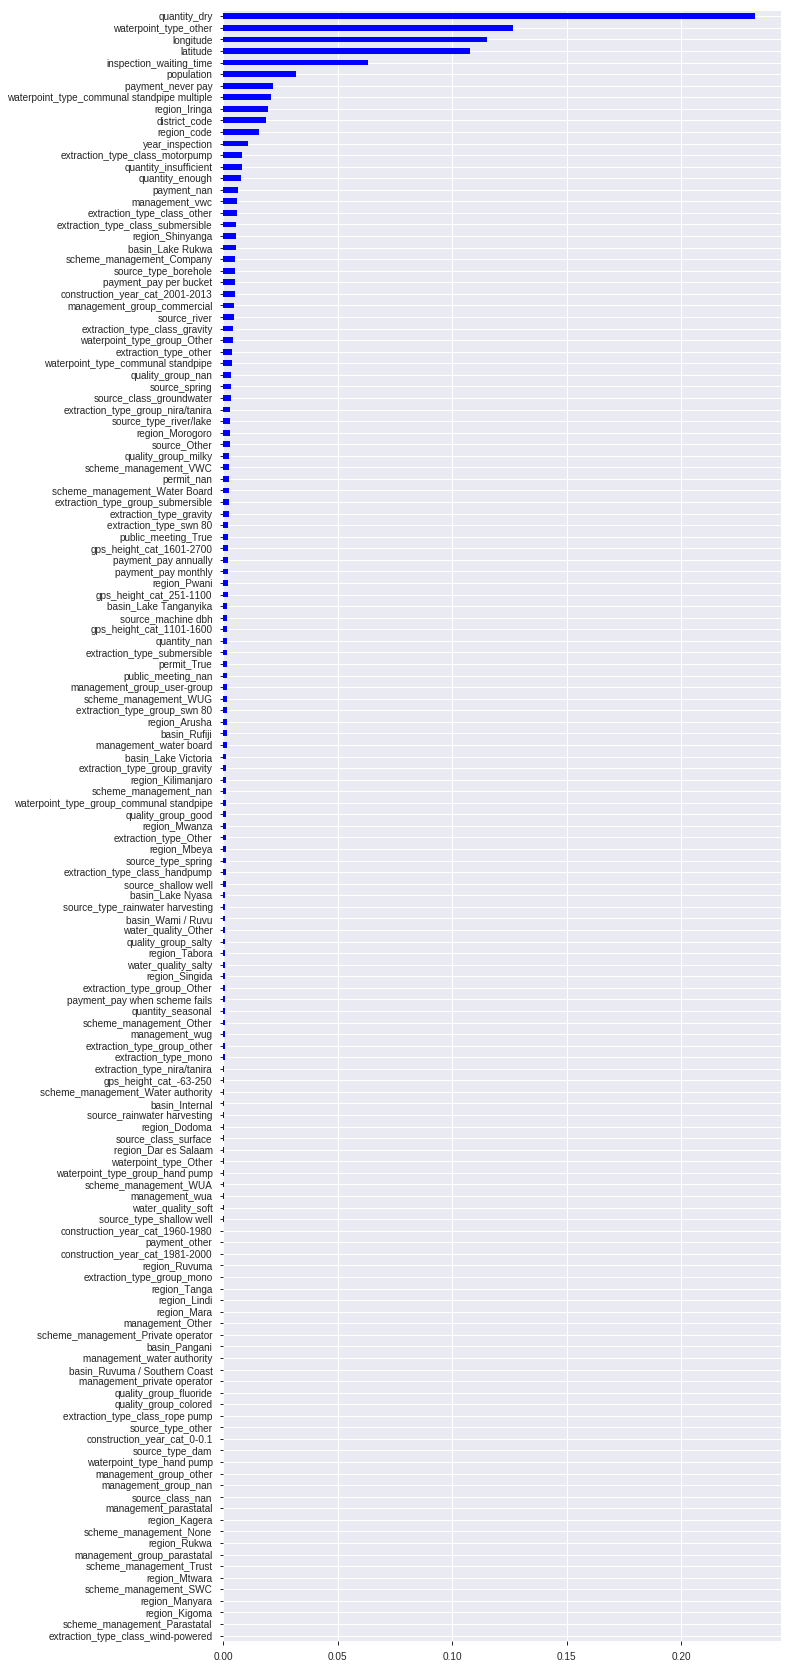

In [146]:
%matplotlib inline
# model = pipeline.named_steps['decisiontreeclassifier']
encoder = pipeline.named_steps['onehotencoder']
encoded_columns = encoder.transform(X_val).columns
importances = pd.Series(model.feature_importances_, encoded_columns)
plt.figure(figsize=(10,30))
importances.sort_values().plot.barh(color='blue');

In [147]:

model.feature_importances_

array([1.15065857e-01, 1.07855235e-01, 1.56131701e-02, 1.88400137e-02,
       3.16587111e-02, 1.06582802e-02, 6.33928508e-02, 9.95773214e-04,
       1.54786277e-03, 9.59015189e-04, 1.43171661e-03, 5.04340383e-04,
       1.87694132e-03, 3.61420425e-05, 5.46856638e-03, 4.60028163e-06,
       1.16903206e-03, 1.96039445e-02, 2.02012505e-03, 0.00000000e+00,
       4.47049499e-04, 0.00000000e+00, 1.57047253e-03, 1.21960191e-03,
       0.00000000e+00, 9.48534261e-05, 1.39696743e-03, 0.00000000e+00,
       8.37407965e-05, 0.00000000e+00, 2.86171341e-03, 5.68431543e-03,
       1.23201782e-04, 9.14235514e-04, 8.32690939e-05, 8.91161792e-04,
       4.18244159e-04, 2.20353481e-03, 1.74037120e-03, 2.69243030e-03,
       3.72426497e-04, 1.32033005e-03, 5.16474768e-04, 0.00000000e+00,
       5.36990849e-03, 6.61297404e-05, 1.63473669e-03, 2.66751556e-03,
       8.40074795e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.67088025e-03, 1.75048300e-03, 2.38217910e-03, 1.21529314e-03,
      